In [2]:
import PCE_module as p
import TestFunctions as testf
import MLMC_module as mlmc

import numpy as np
import numpy.random as rnd
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt

%matplotlib inline

## Now that we can estimate individual PCE coefficients with MLMC and optimal sampling, we want to extend this to ensembles of PCE coefficients. There are a few options on how to do this, listed in order of increasing complexity:
1. **Individual sampling:** each coefficient has its own optimal sampling conditions, does not consider the other coefficients. This option, while simple to implement, is expensive.
2. **Worst case sampling:** use optimal sampling for the coefficient with the largest variance, as determined with pilot samples. This option could result in poor resolution of the coefficients that are not targeted. 
3. **Global sample allocation:** need the derivation for this

In [3]:
# Define a multi-level instance of the Ishigami function, a MLM class
Ishigami = mlmc.Multi_Level_Model('Ishigami')
Ishigami.basis = 'legendre'
Ishigami.basis_params = np.array([-np.pi, np.pi])
Ishigami.variables = 3
fun1 = lambda x: testf.Ishigami(x, 0.6*7.0, 0.6*0.1)
Ishigami.add_level(fun1, 1.0, testf.var_ishigami(0.6*7.0, 0.6*0.1))
fun2 = lambda x: testf.Ishigami(x, 0.8*7.0, 0.8*0.1)
Ishigami.add_level(fun2, 10.0, testf.var_correction(0.8*7.0, 0.8*0.1, 0.6*7.0, 0.6*0.1))
fun3 = lambda x: testf.Ishigami(x, 7.0, 0.1)
Ishigami.add_level(fun3, 100.0, testf.var_correction(7.0, 0.1, 0.8*7.0, 0.8*0.1))
vars(Ishigami)

{'name': 'Ishigami',
 'levels': 3,
 'functions': [<function __main__.<lambda>(x)>,
  <function __main__.<lambda>(x)>,
  <function __main__.<lambda>(x)>],
 'costs': array([  1.,  10., 100.]),
 'var_analytical': [5.7716152956221425,
  0.45585624480156867,
  0.4558562448015679],
 'basis': 'legendre',
 'basis_params': array([-3.14159265,  3.14159265]),
 'variables': 3}

In [4]:
# These functions are just provided as a reference during code development

def generate_samples(N, MLM, samples, samples_on_ab):
    '''Given a vector of number of samples to add by level, return input random variables.
    Think of N as a DeltaN_l vector of number of new samples by level'''
    A, B = MLM.basis_params # these can be uniform bounds or normal mu and sigma
    vars = MLM.variables # this needs to be variable, determined by function
    L = MLM.levels
    
    # for initializing the samples
    if not(samples) and not(samples_on_ab):
        samples = [[]]*L; samples_on_ab = [[]]*L
        for i in range(L):
            if MLM.basis == 'legendre':
                samples_on_ab[i] = rnd.uniform(A, B, (vars,N[i]))
                samples[i] = p.transf_uniform(samples_on_ab[i], A, B) 
            elif MLM.basis == 'hermite':
                samples_on_ab[i] = rnd.normal(A, B, (vars,N[i]))
                samples[i] = p.transf_normal(samples_on_ab[i], A, B)
    # for enlarging the samples
    else:
        for i in range(L):
            if MLM.basis == 'legendre':
                newsamples_on_ab = rnd.uniform(A, B, (vars,N[i]))
                newsamples = p.transf_uniform(newsamples_on_ab, A, B) 
                samples_on_ab[i] = np.append(samples_on_ab[i], newsamples_on_ab, axis=1)
                samples[i] = np.append(samples[i], newsamples, axis=1)
            elif MLM.basis == 'hermite':
                newsamples_on_ab = rnd.normal(A, B, (vars,N[i]))
                newsamples = p.transf_normal(newsamples_on_ab, A, B)
                samples_on_ab[i] = np.append(samples_on_ab[i], newsamples_on_ab, axis=1)
                samples[i] = np.append(samples[i], newsamples, axis=1)

    return samples, samples_on_ab

def sample_polynomial(N, MLM, samples, sampled_polynomials, multiindex):
    ''' Takes the newly generated samples and evaluates the orthogonal polynomial.
    Think of N as a DeltaN_l vector of number of new samples by level '''
    if not(sampled_polynomials):
        sampled_polynomials = [[]]*MLM.levels
    else:
        pass
    for i in range(MLM.levels):
        L_update = np.zeros((N[i],))
        start = len(sampled_polynomials[i])
        for j in range(N[i]):
            L_update[j] = p.evaluate_orthogonal_polynomials(multiindex, samples[i][:,start+j], MLM.basis)
        sampled_polynomials[i] = np.append(sampled_polynomials[i], L_update)
    
    return sampled_polynomials

def evaluate_ML_functions(N, MLM, samples_on_ab, function_evals):
    ''' Takes the newly generated samples and evaluates the function at them.
    Think of N as a DeltaN_l vector of number of new samples by level'''
    if not(function_evals):
        function_evals = [[]]*MLM.levels
    else:
        pass
    for i in range(MLM.levels):
        fun_update = np.zeros((N[i],)) 
        start = len(function_evals[i])
        if i == 0:
            fun_update = MLM.functions[i](samples_on_ab[i][:,start:]) # only for first level
        else: 
            fun_update = MLM.functions[i](samples_on_ab[i][:,start:]) - MLM.functions[i-1](samples_on_ab[i][:,start:])
        function_evals[i] = np.append(function_evals[i], fun_update)
    
    return function_evals

def sample_allocation(function_evals, sampled_polynomials, MLM, eps2, N, polynomial_norm):
    '''Evaluates the sample variance with the given function evaluations and returns the optimal 
    sample allocation strategy, given a target variance reduction, subject to total cost. Reference
    for sample allocation: Giles, Michael B. "Multilevel monte carlo methods." Acta Numerica (2015)'''
    var_sampled = np.zeros((MLM.levels,))
    for i in range(MLM.levels):
        # compute sampled variance and store it for each level
        var_sampled[i] = np.var(function_evals[i][:N[i]] * sampled_polynomials[i][:N[i]]) / polynomial_norm
        
    # compute the Lagrange multiplier
    mu = np.sum(np.sqrt( var_sampled * MLM.costs )) / eps2
    N_opt = np.round(mu * np.sqrt(var_sampled / MLM.costs)).astype(int)
    
    return var_sampled, N_opt 

In [5]:
def estimate_pce_ensemble(K, eps2, MLM, max_iters, method='individual'):
    '''This code estimates a set of PCE coefficients K using an L level MLMC scheme. 
    The essential inputs are the index of the coefficient k, the target accuracy eps2,
    a and multi level function class with the other relevant pieces.
    
    The method specified can be either individual, worst-case, or global, each enatailing
    a different method for sample allocation across PCE modes.
    
    The indexing of function evaluations and such follows the convention that the first index
    refers to the PCE coefficient and the second refers to function level.'''
    # Initialization
    vars = MLM.variables # this needs to be variable, determined by function
    L = MLM.levels
    C = MLM.costs
    P = len(K)
    BETA = np.zeros((P,))
    COST = np.zeros((P,))
    multiindices_full = p.EvalMulti_totdeg(vars,max(K)) # must be a better way for this
    multiindices = multiindices_full[:,K] # the multi-indices we need
    polynomial_norms = p.get_polynomial_norms(multiindices, MLM.basis)
    samples = [[]]*P; samples_on_ab = [[]]*P
    sampled_polynomials = [[]]*P; function_evals = [[]]*P
    
    if method=='individual':
        N_opt = np.zeros((P,L))
        for i in range(P):
            print('----------------Estimating coefficient', K[i],'----------------')
            function_evals[i], BETA[i], sampled_polynomials[i], N_opt[i,:], COST[i] = \
            mlmc.estimate_kth_pce_coef(K[i], eps2, MLM, max_iters)
            
    if method=='worst-case':
        delta_N = [20]*L   # start with 20 pilot samples
        N_by_level = [20]*L
        N_opt = np.zeros((P,L))
        var_sampled = np.zeros((P,L))
        estim_var = np.zeros((P,L))
        iters = 1
        while max(delta_N) > 0 and iters < max_iters:
            print('Iteration: ',iters)
            N_opt_old = np.copy(N_by_level)
            for j in range(P):
                samples[j], samples_on_ab[j] = generate_samples(delta_N, MLM, samples[j], samples_on_ab[j])
                sampled_polynomials[j] = sample_polynomial(delta_N, MLM, samples[j], sampled_polynomials[j], multiindices[:,j])
                function_evals[j] = evaluate_ML_functions(delta_N, MLM, samples_on_ab[j], function_evals[j])
                var_sampled[j,:], N_opt[j,:] = sample_allocation(function_evals[j], sampled_polynomials[j], MLM, eps2, N_opt_old, polynomial_norms[j])
                estim_var = var_sampled / N_opt_old  # new variance estimate computed with old sampling
            # Determine global sample allocation by finding the worst case, highest variance, PCE coefficient
            print('Variance of coefficient estimators: ', np.sum(estim_var,1))
            wc_idx = np.argmax(estim_var, axis=0)
            N_by_level = N_opt[wc_idx,np.arange(L)].astype(int)
            print('Worst case sampling by level: ',N_by_level)
            print('Worst case coefficient index by level: ',wc_idx)
            delta_N_raw = N_by_level - N_opt_old
            delta_N = np.array(N_by_level - N_opt_old).clip(min=0)
            print('Change in sample allocation: ', delta_N_raw)
            iters += 1

        #Post-processing
        numerator = np.zeros((P,))
        for j in range(P):
            for i in range(MLM.levels):
                numer_update = np.sum(function_evals[j][i][:N_by_level[i]] * sampled_polynomials[j][i][:N_by_level[i]])
                numerator[j] += ((numer_update) / N_by_level[i])
        BETA = numerator / polynomial_norms
        # the cost is the same for each coefficient, so it is repeated P times
        COST = [np.sum(C*N_by_level) + np.sum(C[1:]*N_by_level[1:])]*P  # does not count oversampling cost
        N_opt = N_by_level
        
        if method == 'global':
            print('still working on this option...')

    return function_evals, BETA, sampled_polynomials, N_opt, COST

In [6]:
%%time
f_evals, BETA_wc, sampled_poly, N_opt, COST_wc = estimate_pce_ensemble([0,1,2,7,10,15], 1e-3, Ishigami, 50, 'worst-case')

Iteration:  1
Variance of coefficient estimators:  [0.34477077 0.4783278  0.37370292 0.15007054 0.35601952 1.46508223]
Worst case sampling by level:  [84343  8964  1934]
Worst case coefficient index by level:  [5 5 1]
Change in sample allocation:  [84323  8944  1914]
Iteration:  2
Variance of coefficient estimators:  [0.0003429  0.00065752 0.0006279  0.00031478 0.00065498 0.00085689]
Worst case sampling by level:  [63634  6202  1834]
Worst case coefficient index by level:  [5 5 5]
Change in sample allocation:  [-20709  -2762   -100]
CPU times: user 25.4 s, sys: 220 ms, total: 25.6 s
Wall time: 26.5 s


In [7]:
print('BETA: ', BETA_wc)
print('COST: ', COST_wc, '=', np.sum(COST_wc))

BETA:  [ 3.5047582   2.75266524 -0.02059692 -1.36391982 -3.33506832  5.17096772]
COST:  [554474.0, 554474.0, 554474.0, 554474.0, 554474.0, 554474.0] = 3326844.0


In [8]:
%%time
f_evals, BETA_ind, sampled_poly, N_opt, COST_ind = estimate_pce_ensemble([0,1,2,7,10,15], 1e-3, Ishigami, 50, 'individual')

----------------Estimating coefficient 0 ----------------
Iteration:  1
Sampled variance:  [3.32458081 0.25478402 0.34967729]
Sampling by level:  [17017  1490   552]
Change in sample allocation:  [16997, 1470, 532]
Iteration:  2
Sampled variance:  [5.83878203 0.44375021 0.4469102 ]
Sampling by level:  [27083  2361   749]
Change in sample allocation:  [10066, 871, 197]
Iteration:  3
Sampled variance:  [5.81649766 0.44595996 0.44572862]
Sampling by level:  [27011  2365   748]
Change in sample allocation:  [-72, 4, -1]
Iteration:  4
Sampled variance:  [5.81522521 0.44580027 0.44618102]
Sampling by level:  [27015  2365   748]
Change in sample allocation:  [4, 0, 0]
Iteration:  5
Sampled variance:  [5.81520511 0.44580027 0.44618102]
Sampling by level:  [27015  2365   748]
Change in sample allocation:  [0, 0, 0]
total cost:  223915.0
estimated variance of beta k:  0.0010002561247834656
----------------Estimating coefficient 1 ----------------
Iteration:  1
Sampled variance:  [1.07418228 0.22

In [9]:
print('BETA: ', BETA_ind)
print('COST: ', COST_ind, '=', np.sum(COST_ind))

BETA:  [ 3.51782179  2.6327995  -0.0604572  -1.24847302 -3.28362353  4.22304831]
COST:  [223915. 141025. 133653.  30113.  62700.  33550.] = 624956.0


## Here is a test, where we compare the cost and accuracy of the worst case and individual methods

In [15]:
%%time
NN = 10
BETA_wc = np.zeros((NN, 6)); COST_wc = np.zeros((NN, 6));
BETA_ind = np.zeros((NN, 6)); COST_ind = np.zeros((NN, 6));
for i in range(NN):
    f_evals, BETA_ind[i,:], sampled_poly, N_opt, COST_ind[i,:] = estimate_pce_ensemble([0,1,2,7,10,15], 5e-3, Ishigami, 50, 'individual')
    f_evals, BETA_wc[i,:], sampled_poly, N_opt, COST_wc[i,:] = estimate_pce_ensemble([0,1,2,7,10,15], 5e-3, Ishigami, 50, 'worst-case')

----------------Estimating coefficient 0 ----------------
Iteration:  1
Sampled variance:  [5.21080314 0.57979015 0.7165373 ]
Sampling by level:  [6006  634  223]
Change in sample allocation:  [5986, 614, 203]
Iteration:  2
Sampled variance:  [5.72175637 0.49089067 0.431222  ]
Sampling by level:  [5346  495  147]
Change in sample allocation:  [-660, -139, -76]
total cost:  44646.0
estimated variance of beta k:  0.005470009319489221
----------------Estimating coefficient 1 ----------------
Iteration:  1
Sampled variance:  [1.98782889 0.30070863 0.27646204]
Sampling by level:  [2369  291   88]
Change in sample allocation:  [2349, 271, 68]
Iteration:  2
Sampled variance:  [2.85067077 0.30484988 0.25626217]
Sampling by level:  [2869  297   86]
Change in sample allocation:  [500, 6, -2]
Iteration:  3
Sampled variance:  [2.84542762 0.30466249 0.24862154]
Sampling by level:  [2840  294   84]
Change in sample allocation:  [-29, -3, -2]
total cost:  25520.0
estimated variance of beta k:  0.0148

Variance of coefficient estimators:  [0.00184067 0.00350156 0.00349466 0.00185955 0.00328901 0.00462386]
Worst case sampling by level:  [12926  1211   371]
Worst case coefficient index by level:  [5 5 5]
Change in sample allocation:  [3201 -246  -85]
Iteration:  3
Variance of coefficient estimators:  [0.00197371 0.00392521 0.00377381 0.00206764 0.00373954 0.00490876]
Worst case sampling by level:  [12723  1228   360]
Worst case coefficient index by level:  [5 5 5]
Change in sample allocation:  [-203   17  -11]
Iteration:  4
Variance of coefficient estimators:  [0.00196569 0.00390855 0.00387692 0.00206855 0.00379928 0.00497133]
Worst case sampling by level:  [12724  1228   356]
Worst case coefficient index by level:  [5 5 5]
Change in sample allocation:  [ 1  0 -4]
Iteration:  5
Variance of coefficient estimators:  [0.00197949 0.0039574  0.00388647 0.00209235 0.00381064 0.00503116]
Worst case sampling by level:  [12758  1232   359]
Worst case coefficient index by level:  [5 5 5]
Change 

Iteration:  2
Sampled variance:  [2.79129235 0.24877047 0.23266243]
Sampling by level:  [2697  255   78]
Change in sample allocation:  [-152, -6, -19]
total cost:  23397.0
estimated variance of beta k:  0.015323274552691741
----------------Estimating coefficient 7 ----------------
Iteration:  1
Sampled variance:  [0.73492395 0.07063624 0.08371176]
Sampling by level:  [787  77  27]
Change in sample allocation:  [767, 57, 7]
Iteration:  2
Sampled variance:  [1.18034567 0.10673562 0.08000799]
Sampling by level:  [1075  102   28]
Change in sample allocation:  [288, 25, 1]
Iteration:  3
Sampled variance:  [1.14448236 0.09157954 0.07820836]
Sampling by level:  [1032   92   27]
Change in sample allocation:  [-43, -10, -1]
total cost:  8272.0
estimated variance of beta k:  0.02566645211931146
----------------Estimating coefficient 10 ----------------
Iteration:  1
Sampled variance:  [2.05818484 0.12721548 0.2522594 ]
Sampling by level:  [2176  171   76]
Change in sample allocation:  [2156, 151

Iteration:  2
Sampled variance:  [5.80529221 0.4880786  0.4259424 ]
Sampling by level:  [5371  492  145]
Change in sample allocation:  [947, -42, -33]
Iteration:  3
Sampled variance:  [5.9081171  0.50051046 0.43742807]
Sampling by level:  [5484  505  149]
Change in sample allocation:  [113, 13, 4]
Iteration:  4
Sampled variance:  [5.87840992 0.49359248 0.43489284]
Sampling by level:  [5451  499  148]
Change in sample allocation:  [-33, -6, -1]
total cost:  45031.0
estimated variance of beta k:  0.005026775116539484
----------------Estimating coefficient 1 ----------------
Iteration:  1
Sampled variance:  [5.18876589 0.28089444 0.35300524]
Sampling by level:  [4508  332  118]
Change in sample allocation:  [4488, 312, 98]
Iteration:  2
Sampled variance:  [2.76478587 0.29750233 0.27324932]
Sampling by level:  [2865  297   90]
Change in sample allocation:  [-1643, -35, -28]
total cost:  26805.0
estimated variance of beta k:  0.015093267190085897
----------------Estimating coefficient 2 ---

Variance of coefficient estimators:  [0.00213561 0.00361943 0.00368026 0.00196805 0.00382218 0.00543042]
Worst case sampling by level:  [13028  1295   399]
Worst case coefficient index by level:  [5 5 5]
Change in sample allocation:  [ 5161 -1018    26]
Iteration:  3
Variance of coefficient estimators:  [0.00190688 0.00335985 0.00338625 0.00176996 0.00348798 0.00503809]
Worst case sampling by level:  [13186  1334   398]
Worst case coefficient index by level:  [5 5 5]
Change in sample allocation:  [158  39  -1]
Iteration:  4
Variance of coefficient estimators:  [0.00189184 0.00334656 0.00335824 0.00175468 0.00347351 0.0049977 ]
Worst case sampling by level:  [13162  1327   399]
Worst case coefficient index by level:  [5 5 5]
Change in sample allocation:  [-24  -7   1]
Iteration:  5
Variance of coefficient estimators:  [0.00189014 0.00334088 0.00335982 0.00175215 0.00347314 0.0049937 ]
Worst case sampling by level:  [13164  1327   398]
Worst case coefficient index by level:  [5 5 5]
Chan

Iteration:  2
Sampled variance:  [2.87148573 0.27171439 0.29736629]
Sampling by level:  [2981  290   96]
Change in sample allocation:  [-627, 73, 8]
Iteration:  3
Sampled variance:  [2.8280574  0.27764064 0.2840196 ]
Sampling by level:  [2918  289   92]
Change in sample allocation:  [-63, -1, -4]
total cost:  27098.0
estimated variance of beta k:  0.015151310166133487
----------------Estimating coefficient 7 ----------------
Iteration:  1
Sampled variance:  [0.96045816 0.06264089 0.04407538]
Sampling by level:  [759  61  16]
Change in sample allocation:  [739, 41, -4]
Iteration:  2
Sampled variance:  [0.93392875 0.0577072  0.05004654]
Sampling by level:  [766  60  18]
Change in sample allocation:  [7, -1, 2]
Iteration:  3
Sampled variance:  [0.93507166 0.05832982 0.04812849]
Sampling by level:  [759  60  17]
Change in sample allocation:  [-7, 0, -1]
total cost:  5359.0
estimated variance of beta k:  0.024873623450241328
----------------Estimating coefficient 10 ----------------
Iterati

individual sampling beta =  3.4506046377278894 +/- 0.006278533796877898 with mean cost 45425.5
worst case sampling beta =  3.495749664171279 +/- 0.0021835027902270846 with mean cost 115364.5


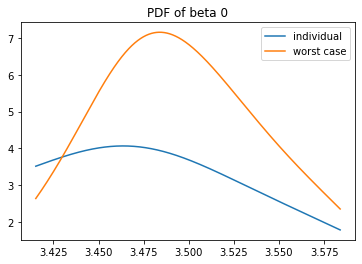

In [16]:
k = 0; coefs = [0, 1, 2, 7, 10, 15]
x_pts = np.linspace(min(BETA_wc[:,k]), max(BETA_wc[:,k]), 1000)
plt.plot(x_pts, gaussian_kde(BETA_ind[:,k])(x_pts))
plt.plot(x_pts, gaussian_kde(BETA_wc[:,k])(x_pts))
print('individual sampling beta = ', np.mean(BETA_ind[:,k]), '+/-', np.var(BETA_ind[:,k]), 'with mean cost', np.mean(COST_ind[:,k]))
print('worst case sampling beta = ', np.mean(BETA_wc[:,k]), '+/-', np.var(BETA_wc[:,k]), 'with mean cost', np.mean(COST_wc[:,k]))
plt.title('PDF of beta '+str(coefs[k]))
plt.legend(['individual','worst case'])

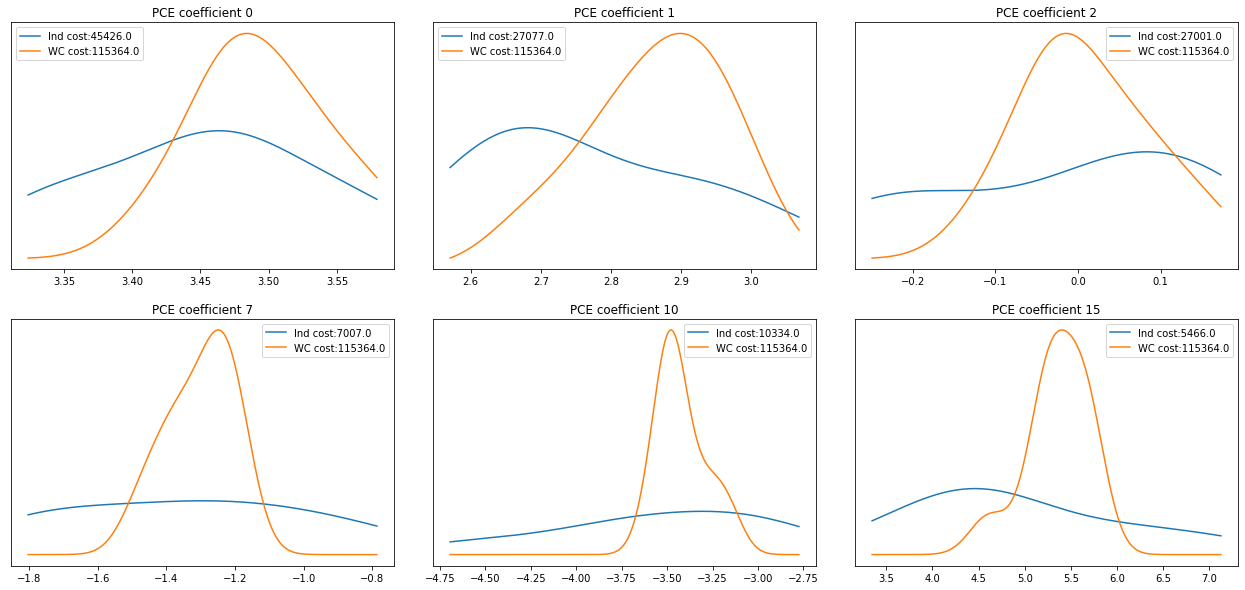

In [17]:
# Create a subplot figure
fig, axs = plt.subplots(2,3, figsize=(22, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

for i in range(6):
    x_pts = np.linspace(min(BETA_ind[:,i]), max(BETA_ind[:,i]), 1000)
    axs[i].plot(x_pts, gaussian_kde(BETA_ind[:,i])(x_pts))
    axs[i].plot(x_pts, gaussian_kde(BETA_wc[:,i])(x_pts))
    axs[i].set_title('PCE coefficient %d' %coefs[i])
    axs[i].legend(['Ind cost:'+str(np.round(np.mean(COST_ind[:,i]))),'WC cost:'+str(np.round(np.mean(COST_wc[:,i])))])
    
for ax in axs:
    ax.set_yticks([])
    
#plt.savefig('ishigami_ensemble_comparison', fmt='pdf')